In [93]:
using Interact
using Images         # This is needed every time the kernel is started or reloaded
using PyPlot

INFO: Loading help data...


# Larson Hogstrom/ 18.337/ HW2

## Improved ImageSeam energy function for single-axis dominant images

This notebook shows the development of a modified energy function to speed up ImageSeam for images where the variance in brightness is dominated along a single axis. The modification to the energy function yielded about a %46 improvement when run on a single processor. More importantly, the modified $\textbf{showed better subjective image compression}$ in some cases. It is important to note that the modified algorithm is best applied to images that have linear or grid-like features. Here is a figure of the main results:

<img src=main_results.png width=800>


### 2. BRIGHTNESS

In [5]:
# brightness of a color is the sum of the r,g,b values (stored as float32's)
brightness(c)        =  c.r + c.g + c.b

# brightness of an image bordered with zeros
function brightness(I::Image)
  w, h = size(I)
  b = [brightness(I[x,y]) for x=1:w, y=1:h]
  # borders
  zv = fill(0f0,1,  h)  #  vertical zero 
  zh = fill(0f0,w+2,1)  #  horizontal zero 
  [zh  [zv; b; zv]  zh] 
 end

brightness (generic function with 2 methods)

### 3. ENERGY

In [129]:
# the 3x3 stencil for energy
function stencil(b)
      xenergy = b[1,1]+2b[2,1]+b[3,1]-b[1,3]-2b[2,3]-b[3,3]
      yenergy = b[1,1]+2b[1,2]+b[1,3]-b[3,1]-2b[3,2]-b[3,3]
      √(xenergy^2 + yenergy^2)
end
    
# energy of an array of brightness values 
# input: assumed zero borders
# output: left and right set to ∞
function energy(b)
  w, h = size(b)
  e = [float32(stencil( b[x-1:x+1, y-1:y+1] )) for x=2:w-1,y=2:h-1]
  infcol = fill(Inf32,1,h-2)
  [infcol; e; infcol]
end

energy (generic function with 1 method)

In [166]:
### modified stencil and energy function function - examines only the contribution of the y-axis to energy

# the 3x3 stencil for energy
function stencil_mod(b)
      #xenergy = b[1,1]+2b[2,1]+b[3,1]-b[1,3]-2b[2,3]-b[3,3]
      yenergy = b[1,1]+2b[1,2]+b[1,3]-b[3,1]-2b[3,2]-b[3,3]
      √(yenergy^2 + yenergy^2)
      #√(xenergy^4 + yenergy^4)
end

# the 3x3 stencil for energy - weight x and y energy differently
#alpha = .5
#function stencil_mod(b)
#      xenergy = b[1,1]+2b[2,1]+b[3,1]-b[1,3]-2b[2,3]-b[3,3]
#      yenergy = b[1,1]+2b[1,2]+b[1,3]-b[3,1]-2b[3,2]-b[3,3]
#      √(2*aplha*yenergy^2 + 2*(1-apha)*xenergy^2)
#      #√(xenergy^4 + yenergy^4)
#end
    
# energy of an array of brightness values 
# input: assumed zero borders
# output: left and right set to ∞
function energy_mod(b)
  w, h = size(b)
  e = [float32(stencil_mod( b[x-1:x+1, y-1:y+1] )) for x=2:w-1,y=2:h-1]
  infcol = fill(Inf32,1,h-2)
  [infcol; e; infcol]
end

energy_mod (generic function with 1 method)

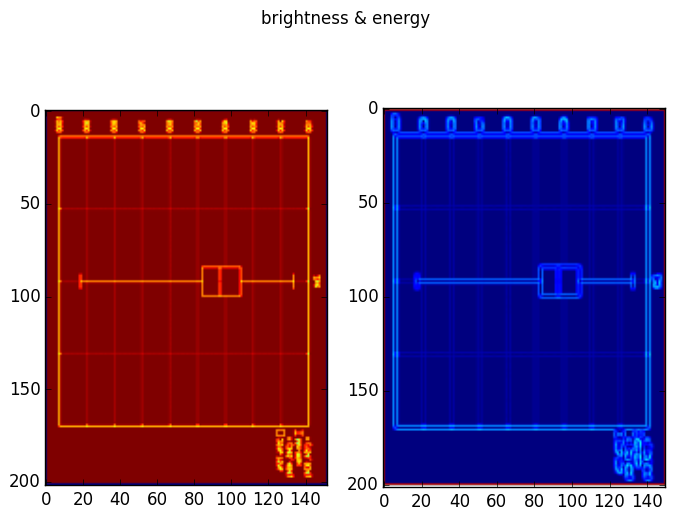

PyObject <matplotlib.text.Text object at 0x11c4821d0>

In [243]:
### plotting energy function for input image
f="BoxPlot_med.png"
img = imread(f)

#_,dirs  = least_energy(energy(brightness(img)))
subplot(121)
brt = brightness(img)
imshow(brt)

subplot(122)
eng = energy(brightness(img))
imshow(eng)
suptitle("brightness & energy")

#c = least_energy(energy(brightness(img)))



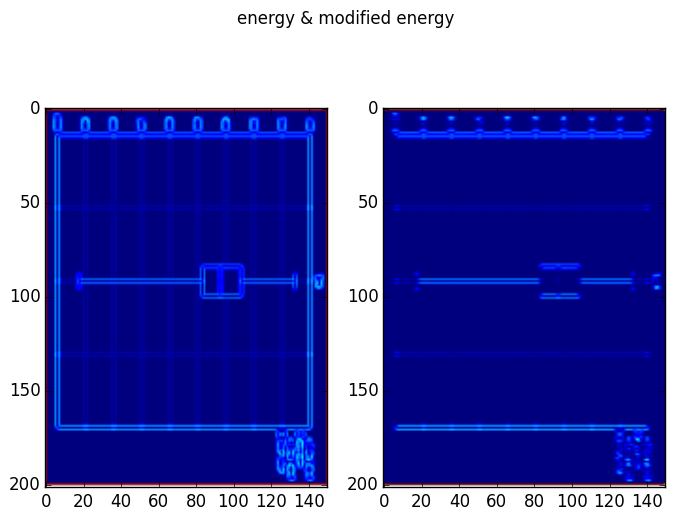

PyObject <matplotlib.text.Text object at 0x11dc48bd0>

In [246]:
### examine compression for y-axis eneregy 

subplot(121)
eng = energy(brightness(img))
imshow(eng)

subplot(122)
eng_mod = energy_mod(brightness(img))
imshow(eng_mod)
suptitle("energy & modified energy")

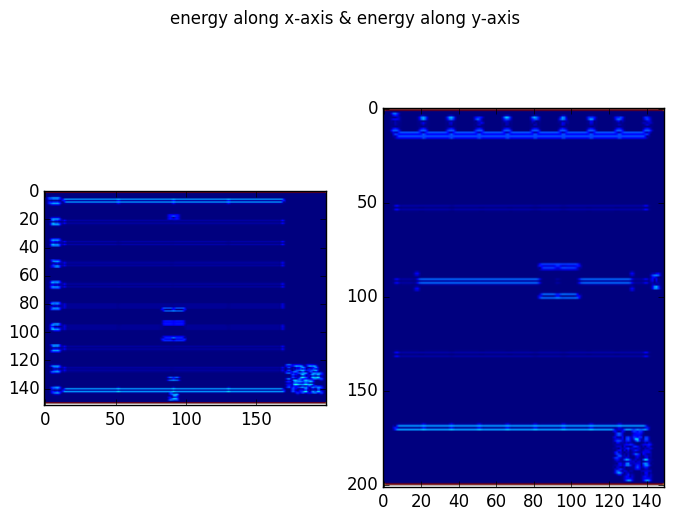

PyObject <matplotlib.text.Text object at 0x13f5ed1d0>

In [247]:
### examine compression along only x-axis and y-axis

subplot(121)
eng_mod_T = energy_mod(brightness(img'))
imshow(eng_mod_T)

subplot(122)
eng_mod = energy_mod(brightness(img))
imshow(eng_mod)
suptitle("energy along x-axis & energy along y-axis")

### 4. LEAST ENERGY FROM BOTTOM TO TOP

In [7]:
#  e (row                  e[x,y] 
#  dirs:                ↙   ↓   ↘       <--directions naturally live between the rows
#  e (row y+1): e[x-1,y+1] e[x,y+1]  e[x+1,y+1]     
# Basic Comp:   e[x,y] += min( e[x-1,y+1],e[x,y],e[x+1,y])
#               dirs records which one from (1==SW,2==S,3==SE)


# Take an array of energies and work up from bottom to top accumulating least energy to bottom
function least_energy(e)
   # initialize dirs 
   w, h = size(e)
   dirs = fill(0, w-2, h-1) # w-2 because we don't need the infs, h-1 because arrows between rows
   # compute
   for y=h-1:-1:1, x=2:w-1          
        s, dirs[x-1,y] = findmin(e[x+[-1, 0, 1], y+1]) # findmin gets the min and the index
        e[x,y] += s   #  add in current energy +  smallest from below
   end
   e[2:w-1,1], dirs  # return top row without infinities and dirs
end

least_energy (generic function with 1 method)

In [221]:
# no longer need to calculate min at each entry of the image matrix - only need to move columnwise

function least_energy_mod(e)
   # initialize dirs 
   w, h = size(e)
   dirs = fill(0, w-2, h-1) # w-2 because we don't need the infs, h-1 because arrows between rows
   # compute - only using y axis
   for x=2:w-1          
        s, dirs[x-1,:] = findmin(sum(e[x+[-1, 0, 1], :],2)) # findmin gets the min and the index
        e[x,:] += s   #  add in current energy +  smallest from below
   end 
   e[2:w-1,1], dirs  # return top row without infinities and dirs
end

least_energy_mod (generic function with 1 method)

### 5. GET and DISPLAY  SEAM FUNCTIONS

In [81]:
function get_seam(dirs,x)
  seam = fill(0,1+size(dirs,2))
  seam[1]=x
  for y=1:size(dirs,2)
    seam[y+1] = seam[y] + dirs[seam[y],y] - 2
  end
  seam
end

using Colors
#Mark a seam
#function mark_seam(img, seam, color=RGB4{U8}(1,1,1))
function mark_seam(img, seam, color=RGB4{U8}(0.494,0.62,0.78))    
    img2 = copy(img)
    for y=1:length(seam)
        img2[seam[y], y]=color
    end
    img2
end

# Everyone just loves this !!!
function manipulate_seam(url::String)
  fn = split(url,"\/")[end]
  if ~isfile(fn)
   run(`wget $url`)
  end
  img = imread(fn)
  #print(size(img))
  _,dirs  = least_energy(energy(brightness(img)))
  @manipulate for x=1:size(img,1)
    mark_seam(img, get_seam(dirs,x))
  end
end


manipulate_seam (generic function with 1 method)

## 6. CARVE SEAM

In [14]:
function minseam(img)
  e, dirs = least_energy(energy(brightness(img)))
  x = indmin(e)
  seam = get_seam(dirs,x)
end
    
    
function carve(img,seam)
  w, h = size(img)
  newimg = copy(img)
  newimg.data  = newimg[1:w-1,:]         # one pixel less wide
  for y=1:h
    s=seam[y]
    newimg[:,y] = img[[1:s-1,s+1:end],y] # delete pixel x=s on row y
  end
  newimg
 end
    
carve(img) = carve(img, minseam(img))  

function carve(img, n::Int)
  img2 = copy(img)
  for i=1:n
    img2 = carve(img2)
  end
  img2
end

carve (generic function with 3 methods)

In [222]:
### modified carve 

function minseam_mod(img)
  e, dirs = least_energy_mod(energy_mod(brightness(img)))
  x = indmin(e)
  seam = get_seam(dirs,x)
end
    
    
function carve_mod(img,seam)
  w, h = size(img)
  newimg = copy(img)
  newimg.data  = newimg[1:w-1,:]         # one pixel less wide
  for y=1:h
    s=seam[y]
    newimg[:,y] = img[[1:s-1,s+1:end],y] # delete pixel x=s on row y
  end
  newimg
 end
    
carve_mod(img) = carve_mod(img, minseam_mod(img))  

function carve_mod(img, n::Int)
  img2 = copy(img)
  for i=1:n
     img2 = carve_mod(img2)
  end
  img2
end

carve_mod (generic function with 3 methods)

## 7. Examples

Slider{Int64}([Input{Int64}] 100,"x",100,1:200)

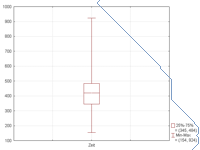

In [82]:
manipulate_seam("BoxPlot_med.png")

In [77]:
# This is a utility function (you do not need to understand it) 
# which overrides Ijulia's image widget so that manipulate displays with the proper width
immutable ImgFrame
    img::Image
end
Base.writemime(io::IO, m::MIME"text/html", frame::ImgFrame) = 
write(io, """<img src="data:image/png;base64,$(stringmime(MIME("image/png"), frame.img))"/>""")

writemime (generic function with 30 methods)

Slider{Int64}([Input{Int64}] 50,"x",50,1:100)

ImgFrame(RGBA Image with:
  data: 150x150 Array{RGBA{UfixedBase{Uint8,8}},2}
  properties:
    imagedescription: <suppressed>
    spatialorder:  x y
    pixelspacing:  1 1)
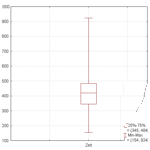

In [150]:
### calculate output in real time

#f="bangalore-dancers-s2.jpg"
f="BoxPlot_med.png"
img = imread(f)

@manipulate for x=1:100
    #img = imread(f)
    #@timed "ImgFrame(carve(img,x))"
    ImgFrame(carve(img,x))
end

In [248]:
#f="BoxPlot_med.png"
f="BoxPlot_medPlus.png"
img = imread(f)

tic()
println("When we reach $(size(img,1)-1) we have carved the image down to 1 pixel wide:")
A=[img for i=1:1] # set up a vector of images
for i=1:size(img,1)-1
    push!(A,carve(A[end]))
    if(rem(i,5)==0) || i==size(img,1)-1 print(i, " ") end
end
t_orig = toc()

When we reach 399 we have carved the image down to 1 pixel wide:
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 399 elapsed time: 51.367606775 seconds


51.367606775

Slider{Int64}([Input{Int64}] 400,"",400,20:400)

ImgFrame(RGBA Image with:
  data: 400x300 Array{RGBA{UfixedBase{Uint8,8}},2}
  properties:
    imagedescription: <suppressed>
    spatialorder:  x y
    pixelspacing:  1 1)
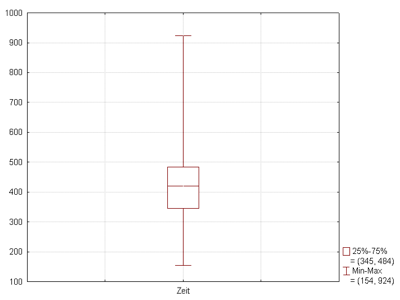

In [234]:
@manipulate for image_width=slider(20:size(img,1), value=size(img,1))
    ImgFrame(A[1+size(img,1)-image_width])
end

When we reach 399 we have carved the image down to 1 pixel wide:
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370

Slider{Int64}([Input{Int64}] 400,"",400,20:400)

 375 380 385 390 395 399 elapsed time: 12.702987901 seconds


ImgFrame(RGBA Image with:
  data: 400x300 Array{RGBA{UfixedBase{Uint8,8}},2}
  properties:
    imagedescription: <suppressed>
    spatialorder:  x y
    pixelspacing:  1 1)
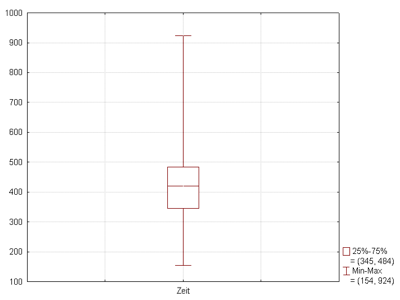

In [235]:
tic()
println("When we reach $(size(img,1)-1) we have carved the image down to 1 pixel wide:")
A=[img for i=1:1] # set up a vector of images
for i=1:size(img,1)-1
    push!(A,carve_mod(A[end]))
    if(rem(i,5)==0) || i==size(img,1)-1 print(i, " ") end
end
t_mod = toc()

@manipulate for image_width=slider(20:size(img,1), value=size(img,1))
    ImgFrame(A[1+size(img,1)-image_width])
end

In [236]:
speed_improvement = (t_orig-t_mod)/t_orig

0.5206777894205856

## The modified energy function works well enough on the Stata image too.

In [238]:
# Stata takes a while to compute, it's worth precomputing and
# then displaying.  Note quantities are being recomputed each time
# unnecessarily when they could be reused.
# One can imagine a lower complexity computation.


if ~isfile("Wfm_stata_center.jpg")
  run(`wget http://upload.wikimedia.org/wikipedia/commons/2/25/Wfm_stata_center.jpg`)
end
img = imread("Wfm_stata_center.jpg")


#Charminar
#=
if ~isfile("2.jpg")
  run(`wget http://www.prasannaholidays.com/wp-content/uploads/2015/03/charminar_hyderabad-400x300.jpg`)
end
img = imread("charminar_hyderabad-400x300.jpg")
=#
#Singapore
#=
if ~isfile("2.jpg")
    run(`wget http://media-cdn.tripadvisor.com/media/photo-s/01/5d/02/31/merlion-statue-at-merlion.jpg`)
end
img = imread("merlion-statue-at-merlion.jpg")
=#


println("When we reach $(size(img,1)-1) we have carved the image down to 1 pixel wide:")
A=[img for i=1:1] # set up a vector of images
for i=1:size(img,1)-1
    push!(A,carve_mod(A[end]))
    if(rem(i,5)==0) || i==size(img,1)-1 print(i, " ") end
end


When we reach 663 we have carved the image down to 1 pixel wide:
5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360 365 370 375 380 385 390 395 400 405 410 415 420 425 430 435 440 445 450 455 460 465 470 475 480 485 490 495 500 505 510 515 520 525 530 535 540 545 550 555 560 565 570 575 580 585 590 595 600 605 610 615 620 625 630 635 640 645 650 655 660 663 

In [31]:
size(img)

(664,593)

Slider{Int64}([Input{Int64}] 664,"",664,20:664)

ImgFrame(RGB4 Image with:
  data: 664x593 Array{RGB4{UfixedBase{Uint8,8}},2}
  properties:
    imagedescription: <suppressed>
    spatialorder:  x y
    pixelspacing:  1 1)
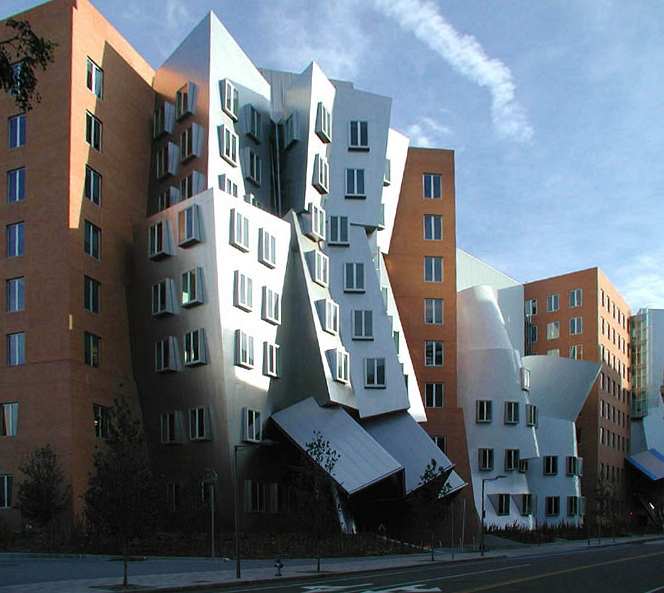

In [239]:
@manipulate for image_width=slider(20:size(img,1), value=size(img,1))
    ImgFrame(A[1+size(img,1)-image_width])
end